In [34]:
# Importando as bibliotecas
import pandas as pd
import tkinter as tk
from tkinter import messagebox
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import scipy.stats as stats

In [35]:
# Ignorar todos os avisos
warnings.filterwarnings("ignore")

# Ajustar opções de exibição para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Ler o arquivo CSV ignorando linhas com erros
df = pd.read_csv(r'C:\Users\lucia\OneDrive\Área de Trabalho\Lista_imoveis_geral.csv',
                 sep=';',
                 encoding='latin1',
                 header=1,
                 error_bad_lines=False)

df.head(1)

,N° do imóvel,UF,Cidade,Bairro,Endereço,Preço,Valor de avaliação,Desconto,Descrição,Modalidade de venda,Link de acesso
0,1555533211373,AC,BUJARI,CENTRO,"RUA ADONIRAN BARBOSA, N. SN, LT 02 QD H","175.000,00","175.000,00",0.0,"Casa, 0.00 de área total, 338.24 de área priva...",Leilão SFI - Edital Único,https://venda-imoveis.caixa.gov.br/sistema/det...


In [36]:
# Função para converter o formato monetário para float
def convert_to_float(value):
    if isinstance(value, str):
        value = value.replace('.', '').replace(',', '.')
        return float(value)
    return value

In [37]:
# Converter as colunas 'Valor de avaliação' e 'Preço' para float
df['Preço'] = df['Preço'].apply(convert_to_float)
df['Valor de avaliação'] = df['Valor de avaliação'].apply(convert_to_float)

In [38]:
# Dividir a coluna 'Descrição' em 5 colunas pelo delimitador ","
descricao_split = df['Descrição'].str.split(',', n=4, expand=True)

# Atribuir nomes às novas colunas
descricao_split.columns = ['tipo', 'area_total', 'area_privativa', 'area_terreno', 'outras_descricoes']

# Anexar as novas colunas ao DataFrame original, se desejado
df = pd.concat([df, descricao_split], axis=1)

# Remover os textos específicos das colunas
df['area_total'] = df['area_total'].str.replace(' de área total', '')
df['area_privativa'] = df['area_privativa'].str.replace(' de área privativa', '')
df['area_terreno'] = df['area_terreno'].str.replace(' de área do terreno', '')

# Remover o caractere "." do final dos valores na coluna específica
df['area_terreno'] = df['area_terreno'].str.rstrip('.')

In [39]:
# Remover espaços em branco adicionais e converter para float
df['area_total'] = df['area_total'].str.strip().str.replace(',', '.').astype(float)
df['area_privativa'] = df['area_privativa'].str.strip().str.replace(',', '.').astype(float)
df['area_terreno'] = df['area_terreno'].str.strip().str.replace(',', '.').astype(float)

In [40]:
# Usar regex para extrair o número de cômodos
df['quartos'] = df['Descrição'].str.extract(r'(\d+)\s*qto\(s\)').astype(float).fillna(0)
df['suites'] = df['Descrição'].str.extract(r'(\d+)\s*suite\(s\)').astype(float).fillna(0)
df['salas'] = df['Descrição'].str.extract(r'(\d+)\s*sala\(s\)').astype(float).fillna(0)
df['lavabos'] = df['Descrição'].str.extract(r'(\d+)\s*lavabo\(s\)').astype(float).fillna(0)
df['vagas_garagem'] = df['Descrição'].str.extract(r'(\d+)\s*vaga\(s\) de garagem').astype(float).fillna(0)
df['edicula'] = df['Descrição'].str.extract(r'(\d+)\s*edícula').astype(float).fillna(0)
df['dce'] = df['Descrição'].apply(lambda x: 1 if 'DCE' in x else 0)
df['wc'] = df['Descrição'].apply(lambda x: 1 if 'WC' in x else 0)
df['wc_emp'] = df['Descrição'].apply(lambda x: 1 if 'WC Emp' in x else 0)
df['sacada'] = df['Descrição'].apply(lambda x: 1 if 'sacada' in x else 0)
df['cozinha'] = df['Descrição'].apply(lambda x: 1 if 'cozinha' in x else 0)
df['terraco'] = df['Descrição'].apply(lambda x: 1 if 'Terraco' in x else 0)
df['aserv'] = df['Descrição'].apply(lambda x: 1 if 'a.serv' in x else 0)
df['churrasqueira'] = df['Descrição'].apply(lambda x: 1 if 'churrasqueira' in x else 0)
df['piscina'] = df['Descrição'].apply(lambda x: 1 if 'piscina' in x else 0)
df['varanda'] = df['Descrição'].apply(lambda x: 1 if 'varanda' in x else 0)
df['sauna'] = df['Descrição'].apply(lambda x: 1 if 'sauna' in x else 0)

In [41]:
# Remove as colunas usando o método drop
df = df.drop(columns=['Descrição','outras_descricoes'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24194 entries, 0 to 24193
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0    N° do imóvel        24194 non-null  int64  
 1   UF                   24194 non-null  object 
 2   Cidade               24194 non-null  object 
 3   Bairro               24194 non-null  object 
 4   Endereço             24194 non-null  object 
 5   Preço                24194 non-null  float64
 6   Valor de avaliação   24194 non-null  float64
 7   Desconto             24194 non-null  float64
 8   Modalidade de venda  24194 non-null  object 
 9   Link de acesso       24194 non-null  object 
 10  tipo                 24194 non-null  object 
 11  area_total           24194 non-null  float64
 12  area_privativa       24194 non-null  float64
 13  area_terreno         24194 non-null  float64
 14  quartos              24194 non-null  float64
 15  suites               24194 non-null 

In [43]:
df.describe()

,N° do imóvel,Preço,Valor de avaliação,Desconto,area_total,area_privativa,area_terreno,quartos,suites,salas,lavabos,vagas_garagem,edicula,dce,wc,wc_emp,sacada,cozinha,terraco,aserv,churrasqueira,piscina,varanda,sauna
count,2.419400e+04,2.419400e+04,2.419400e+04,24194.000000,2.419400e+04,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000,24194.000000
mean,6.861487e+12,1.689619e+05,1.892499e+05,16.843097,2.043703e+02,65.693294,346.560309,1.870794,0.035794,0.916508,0.035422,0.659668,0.000537,0.014880,0.885302,0.023064,0.075019,0.875341,0.072828,0.422543,0.000165,0.000455,0.058940,0.000041
std,3.100236e+12,3.222359e+05,4.023173e+05,20.125339,2.831779e+04,89.306086,4346.950875,0.830287,0.215065,0.428559,0.191654,0.620663,0.024894,0.121074,0.318664,0.150109,0.263427,0.330339,0.259859,0.493974,0.012857,0.021318,0.235518,0.006429
min,1.696600e+04,1.000000e-02,7.700000e+03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.444401e+12,8.398311e+04,1.170677e+05,0.000000,0.000000e+00,44.370000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.444417e+12,1.301844e+05,1.414737e+05,0.000000,0.000000e+00,53.050000,70.345000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.555531e+12,1.759778e+05,1.810000e+05,40.000000,0.000000e+00,67.420000,181.090000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,8.787717e+12,3.745628e+07,5.161400e+07,100.000000,4.400240e+06,6417.000000,381780.000000,28.000000,10.000000,10.000000,3.000000,19.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
df.head(1)

,N° do imóvel,UF,Cidade,Bairro,Endereço,Preço,Valor de avaliação,Desconto,Modalidade de venda,Link de acesso,tipo,area_total,area_privativa,area_terreno,quartos,suites,salas,lavabos,vagas_garagem,edicula,dce,wc,wc_emp,sacada,cozinha,terraco,aserv,churrasqueira,piscina,varanda,sauna
0,1555533211373,AC,BUJARI,CENTRO,"RUA ADONIRAN BARBOSA, N. SN, LT 02 QD H",175000.0,175000.0,0.0,Leilão SFI - Edital Único,https://venda-imoveis.caixa.gov.br/sistema/det...,Casa,0.0,338.24,491.44,2.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,1,0,0,0,0,0,0


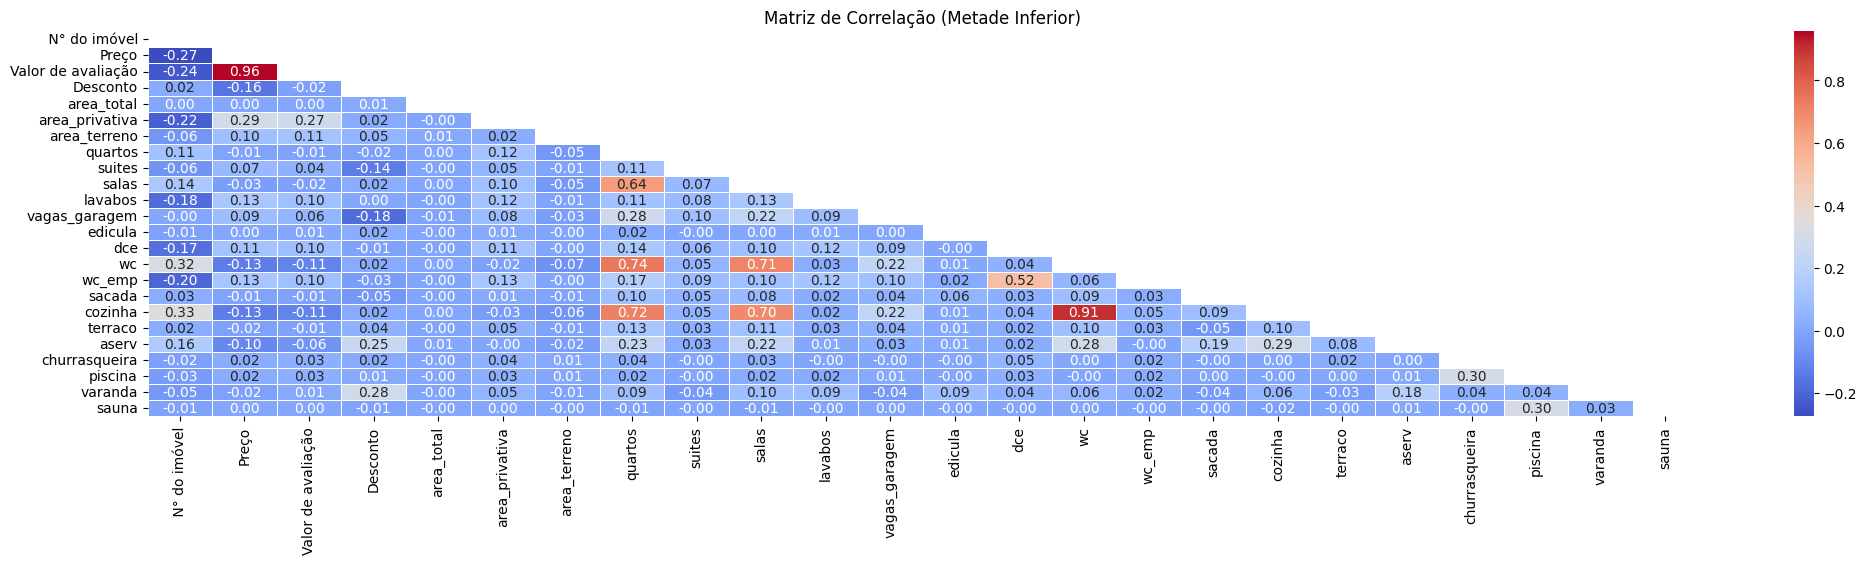

In [45]:
# Calcula a matriz de correlação
correlation_matrix = df.corr()

# Gera uma máscara para a metade superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Configura o tamanho da figura
plt.figure(figsize=(25, 5))

# Cria o mapa de calor usando Seaborn com a máscara
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Título e exibição do gráfico
plt.title('Matriz de Correlação (Metade Inferior)')
plt.show()

In [46]:
# Selecionar as colunas de interesse
features = df.columns.difference(['Preço']).tolist()
target = 'Preço'

In [47]:
# Divisão em dados de treino e teste
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Pré-processamento
numeric_features = df.select_dtypes(exclude=['object']).columns.difference(['Preço']).tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [49]:
# Criação do modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

In [50]:
# Treinamento do modelo
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [' N° do imóvel', 'Desconto',
                                                   'Valor de avaliação',
                                                   'area_privativa',
                                                   'area_terreno', 'area_total',
                                                   'aserv', 'churrasqueira',
                                                   'cozinha', 'dce', 'edicula',
                                                   'lavabos', 'piscina',
                                                 

In [51]:
# Previsões
y_pred = model.predict(X_test)

In [52]:
# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred) # Erro Médio Absoluto (média das diferenças absolutas entre as previsões do modelo e os valores reais) - quanto menor o valor, melhor o desempenho do modelo
mse = mean_squared_error(y_test, y_pred) # Erro Quadrático Médio (média dos quadrados das diferenças entre as previsões do modelo e os valores reais)
rmse = np.sqrt(mse) # Raiz quadrada do Erro Quadrático Médio (quanto menor, melhor)
r2 = r2_score(y_test, y_pred) # Coeficiente de Determinação (proporção da variância na variável dependente, previsível a partir das variáveis independentes) - 0 a 1, mais perto de 1 melhor (ajuste perfeito do modelo a dados)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'r2: {r2}')

# Técnicas de Avaliação Adicionais:
# Análise de Resíduos
    # Analisar a distribuição dos resíduos (diferenças entre os valores reais e previstos) pode revelar padrões ou heterocedasticidade nos erros do modelo.
    # Resíduos normalmente distribuídos e com média próxima de zero indicam um bom ajuste do modelo.
# Validação Cruzada
    # Utilizar técnicas como validação cruzada (por exemplo, validação cruzada k-fold) para avaliar a robustez do modelo e verificar se ele generaliza bem para novos dados
# Comparação com um Modelo Baseline
    # Compare o desempenho do seu modelo com um modelo baseline simples (por exemplo, predizer a média dos valores alvo) para determinar se o seu modelo está proporcionando melhorias significativas
# Interpretação dos Coeficientes (se aplicável)
    # Se o modelo é interpretável (como regressão linear), analise os coeficientes para entender quais variáveis têm maior impacto nos preços dos imóveis

MAE: 27864.138924966694
MSE: 5988362245.712805
RMSE: 77384.50908103511
r2: 0.8897358262421841


In [53]:
# 88,6% da variabilidade nos preços dos imóveis pode ser explicada pelas variáveis independentes incluídas no modelo
# r2 = 0.886: as previsões feitas pelo modelo são bastante confiáveis, pois ele captura uma parte significativa da variabilidade dos preços dos imóveis com base nas características fornecidas
# r2 não diz nada sobre a validade das suposições subjacentes ao modelo (como linearidade, homocedasticidade, independência dos resíduos, etc.)
# É recomendável realizar outras análises, como a análise de resíduos, para verificar a adequação do modelo.

In [54]:
# Comparação das previsões com os preços reais
comparison_df = X_test.copy()
comparison_df['Preço Real'] = y_test
comparison_df['Preço Previsto'] = y_pred
comparison_df['Diferença'] = comparison_df['Preço Previsto'] - comparison_df['Preço Real']

comparison_df.head(1)

,N° do imóvel,Bairro,Cidade,Desconto,Endereço,Link de acesso,Modalidade de venda,UF,Valor de avaliação,area_privativa,area_terreno,area_total,aserv,churrasqueira,cozinha,dce,edicula,lavabos,piscina,quartos,sacada,salas,sauna,suites,terraco,tipo,vagas_garagem,varanda,wc,wc_emp,Preço Real,Preço Previsto,Diferença
8336,8444419220110,IKARAY,VARZEA GRANDE,0.0,"RUA PARA, N. 0, LT 03 QD 09",https://venda-imoveis.caixa.gov.br/sistema/det...,Leilão SFI - Edital Único,MT,190000.0,69.76,180.0,0.0,0,0,1,0,0.0,0.0,0,2.0,0,1.0,0,0.0,0,Casa,1.0,0,1,0,190000.0,185293.969784,-4706.030216


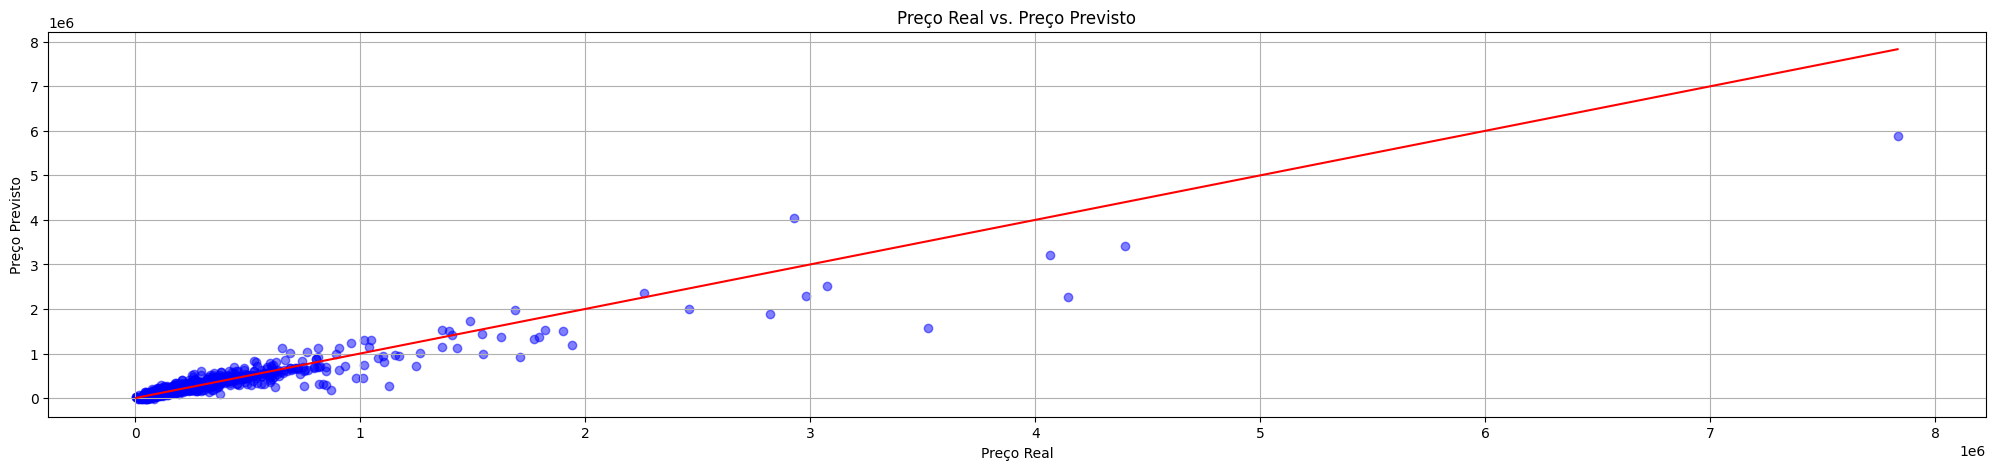

In [55]:
# Plotar o gráfico de dispersão
plt.figure(figsize=(25, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)  # Pontos no gráfico
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Linha diagonal (previsão perfeita)
plt.title('Preço Real vs. Preço Previsto')
plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.grid(True)
plt.show()

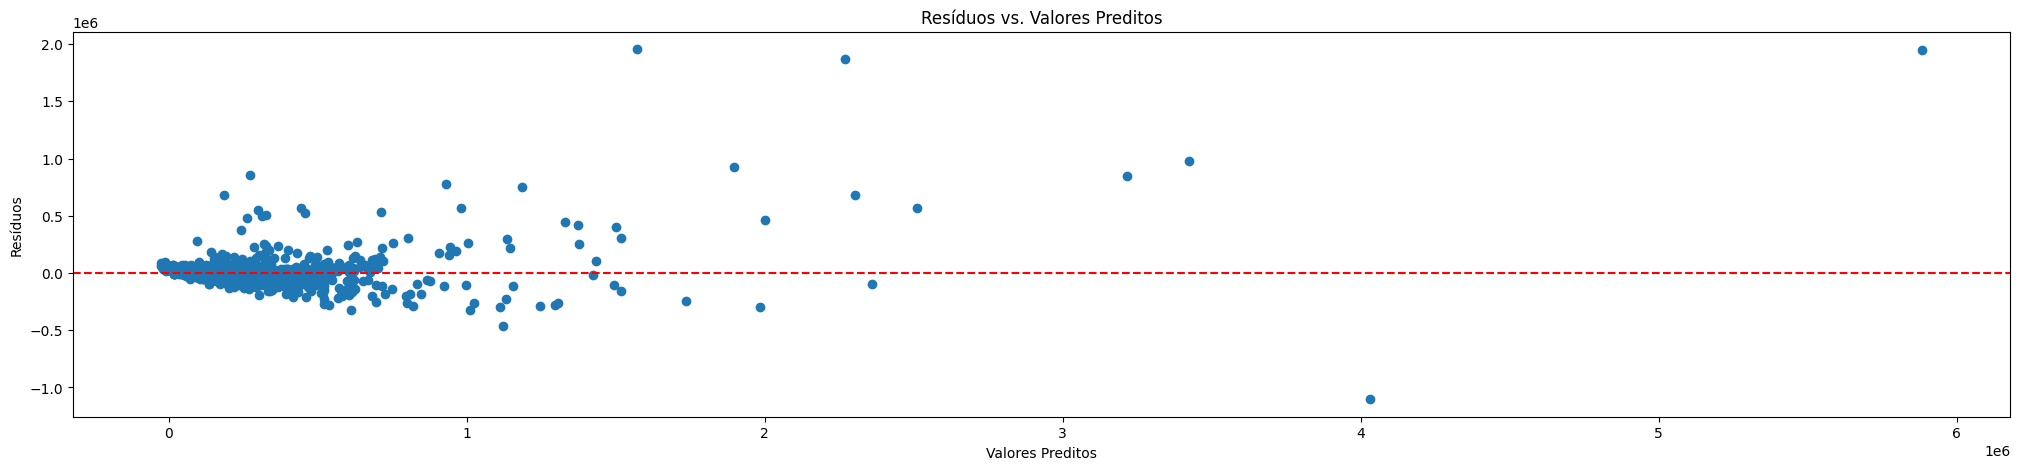

In [56]:
# Calcular resíduos
residuos = y_test - y_pred

# Análise dos Resíduos

# Plotar Resíduos vs. Valores Ajustados
plt.figure(figsize=(25, 5))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Preditos')
plt.show()

In [57]:
# Distribuição Aleatória (Ideal)
# Interpretação: Modelo bem ajustado e apropriado para os dados. 
# Os resíduos parecem distribuídos aleatoriamente ao redor da linha horizontal em zero.
# Isso indica que o modelo está capturando bem a relação entre as variáveis preditoras e a variável de resposta.

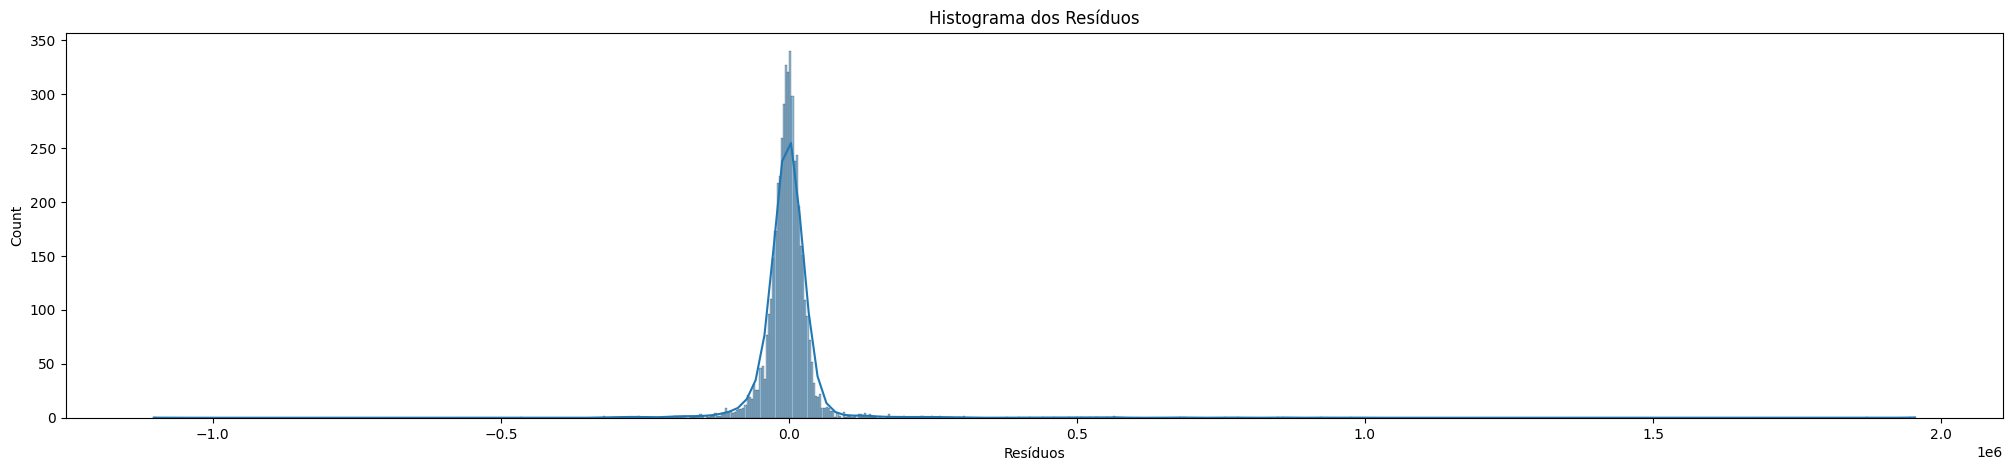

In [58]:
# Histograma dos Resíduos
plt.figure(figsize=(25, 5))
sns.histplot(residuos, kde=True)
plt.xlabel('Resíduos')
plt.title('Histograma dos Resíduos')
plt.show()

In [59]:
# 1. Forma de um Sino simétrico
# Centrado em torno de zero, isso sugere que os resíduos seguem uma distribuição normal.
# Indica que a suposição de normalidade dos resíduos é razoável, o que é uma boa indicação de que o modelo está adequado.

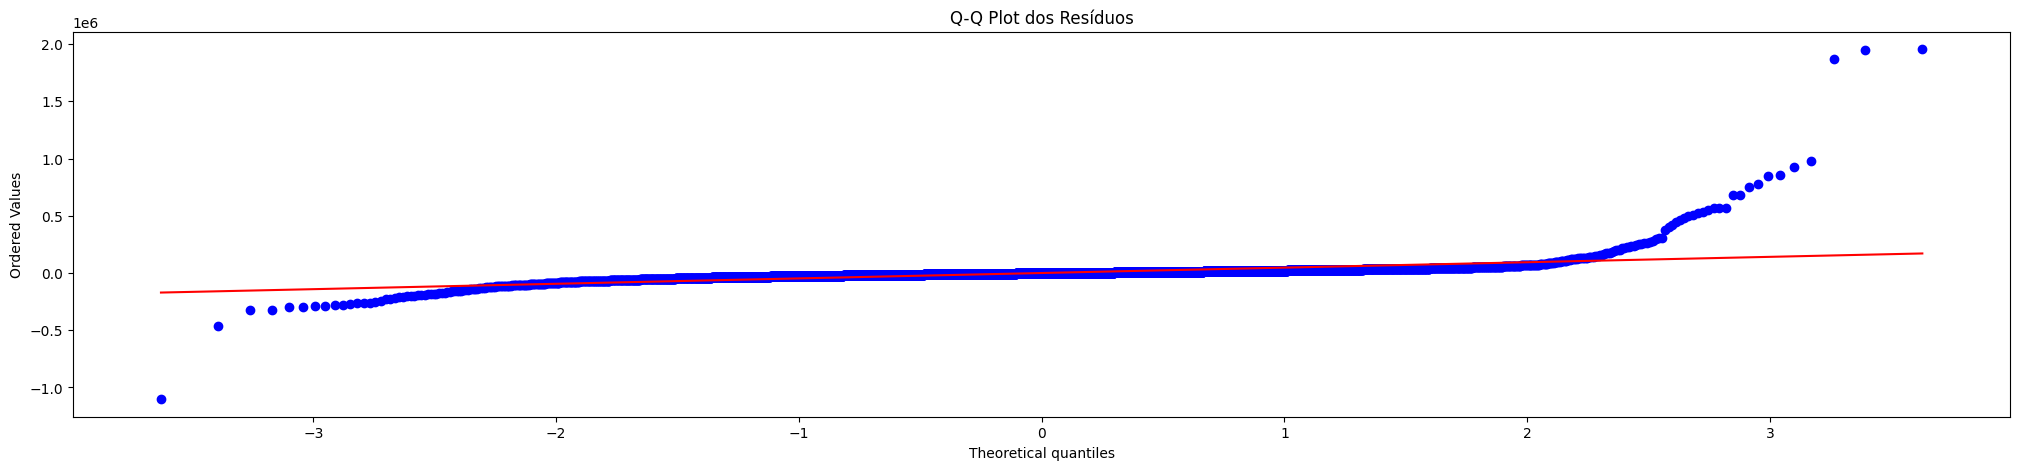

In [60]:
# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(25, 5))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')
plt.show()

In [61]:
# Q-Q Plot com Resíduos Leptocúrticos
# Desvios nas extremidades indicam caudas mais pesadas que o normal, sugerindo presença de outliers.

In [62]:
# Configurando o K-fold cross-validation com K=5 folds
# Estimar como o modelo se comportará em dados não vistos
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Executando a validação cruzada
scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

print(f'Scores de R²: {scores}')
print(f'R² Médio: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')

# Folds: divisão dos dados em partes (ou subconjuntos) para fins de treinamento e teste, é uma amostra representativa dos dados originais, mantendo a estrutura geral da distribuição dos dados
# scoring='r2' indica que estamos utilizando o coeficiente de determinação (R²) como métrica de avaliação
# shuffle=True no KFold garante que os dados sejam embaralhados antes da divisão, o que é importante para evitar viéses em conjuntos de dados ordenados.
# Mais folds podem reduzir o viés de avaliação, mas aumentam o custo computacional.

Scores de R²: [0.88973717 0.9303194  0.78082093 0.83174582 0.86344392]
R² Médio: 0.86 +/- 0.05


In [63]:
# Scores Individuais de R²: Todos esses valores estão relativamente próximos de 1, o que sugere que o modelo está bem ajustado para cada conjunto de teste específico em cada fold.
# R² Médio: Isso significa que, em média, o modelo está explicando aproximadamente 85.4% da variabilidade nos dados observados. Está capturando bem o padrão nos dados e fazendo previsões precisas.
# Intervalo de Confiança (± 0.05): indica a variabilidade na estimativa do R² médio devido à aleatoriedade na seleção dos folds na validação cruzada. 
# Um intervalo de confiança estreito sugere que o desempenho do modelo é consistente.

In [64]:
# Supondo que 'y' seja sua variável alvo
y_mean = np.mean(y)  # Calcula a média da variável alvo

# Cria uma previsão do baseline usando a média
y_pred_baseline = np.full_like(y, y_mean)  # Cria um array com a média repetida

# Calcula o R² do modelo baseline
r2_baseline = r2_score(y, y_pred_baseline)

# Comparação entre os modelos
print(f'R² do Modelo de Regressão Linear: {r2:.4f}')
print(f'R² do Modelo Baseline: {r2_baseline:.4f}')

R² do Modelo de Regressão Linear: 0.8897
R² do Modelo Baseline: 0.0000


In [65]:
# Um R² do modelo de regressão linear maior do que o do modelo baseline sugere que o modelo está fornecendo previsões melhores do que simplesmente usar a média.

In [66]:
comparison_df.to_csv(r'C:\Users\lucia\OneDrive\Área de Trabalho\modelo_regressao_linear_imoveis.csv')